In [1]:
import numpy as np
from utils import (
    SeismicParameters,
    evaluate_ratio,
    calculate_distance_binned_ratios,
    print_dataset_summary,
    compare_waveforms,
    moving_average_envelope_adaptive,
    fft,
)
import matplotlib.pyplot as plt

plt.rc("font", family="serif")
plt.rcParams.update({"font.size": 16})

## Load preprocess data

In [2]:
dataset_raw = SeismicParameters("../experiments/workdir/stead/data/preprocessed_waveforms.h5")
print_dataset_summary(dataset_raw=dataset_raw)

                    DATASET SUMMARY
Number of Data            = 3188
Variable                  Min             Max             Unit      
------------------------------------------------------------
Hypocentral Distance      1.82            199.91          km        
Magnitude                 4.51            7.90                      
Azimuthal Gap             0.05            359.88          degrees   
Vs30                      400.00          1500.00         m/s       
Hypocenter depth          0.10            275.06          km        


## Load the generated and test dataset

In this validation, we will only compare based on test dataset which is 10% of the total dataset

In [3]:
dataset_generated = SeismicParameters("../experiments/workdir/stead/gwm_stead_v1.h5")
print_dataset_summary(dataset_raw=dataset_generated)


dataset_observed = SeismicParameters("../experiments/workdir/stead/test_data.h5")
print_dataset_summary(dataset_raw=dataset_observed)

                    DATASET SUMMARY
Number of Data            = 319
Variable                  Min             Max             Unit      
------------------------------------------------------------
Hypocentral Distance      4.77            198.64          km        
Magnitude                 4.53            6.80                      
Azimuthal Gap             0.10            359.22          degrees   
Vs30                      401.00          1499.00         m/s       
Hypocenter depth          1.00            211.38          km        
                    DATASET SUMMARY
Number of Data            = 319
Variable                  Min             Max             Unit      
------------------------------------------------------------
Hypocentral Distance      4.77            198.64          km        
Magnitude                 4.53            6.80                      
Azimuthal Gap             0.10            359.22          degrees   
Vs30                      401.00          1499.00   

## Calculate PGA and PGV using GMRotD50 

In [4]:
dataset_generated_pga = evaluate_ratio(
    dataset_observed.waveforms, dataset_generated.waveforms, dt=0.01, evaluate_obs=True, PGV=False
)
dataset_generated_pgv = evaluate_ratio(
    dataset_observed.waveforms, dataset_generated.waveforms, dt=0.01, evaluate_obs=True, PGV=True
)

Processing observation...


100%|██████████| 319/319 [00:00<00:00, 2263930.59it/s]

Processing GM0...



100%|██████████| 319/319 [00:00<00:00, 2090598.40it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 319/319 [00:00<00:00, 2441574.77it/s]

Processing GM0...



100%|██████████| 319/319 [00:00<00:00, 2515005.59it/s]


## Plot the ratio between GWM synthetics and the real data

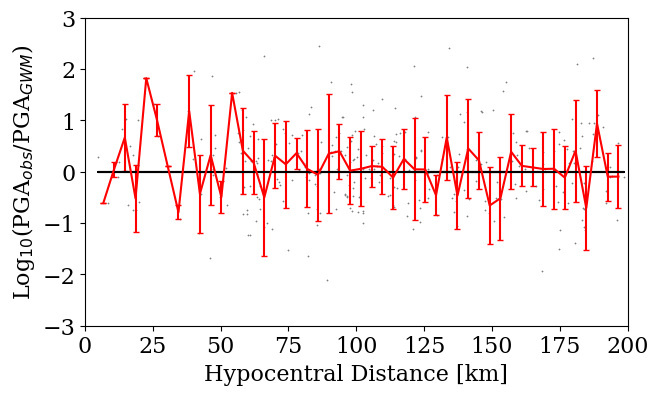

In [5]:
PGA_geom_mean_obs = dataset_generated_pga["PGA_geom_mean_obs"]
PGA_geom_mean_gm0 = dataset_generated_pga["PGA_geom_mean_gwm"]

dataset_generated_stats_PGA = calculate_distance_binned_ratios(
    PGA_geom_mean_obs, PGA_geom_mean_gm0, dataset_generated.hypocentral_distance, n_bins=50
)

fig = plt.figure(figsize=(7, 4))
ax = fig.gca()
ax.plot(
    dataset_generated.hypocentral_distance,
    dataset_generated_stats_PGA["ratio_values"],
    "o",
    c="grey",
    markersize=1,
    markeredgewidth=0.2,
    markeredgecolor="grey",
)
ax.errorbar(
    dataset_generated_stats_PGA["bin_centers"],
    dataset_generated_stats_PGA["median_ratios"],
    yerr=dataset_generated_stats_PGA["std_ratios"],
    color="r",
    capsize=2,
)
ax.plot(
    dataset_generated.hypocentral_distance,
    np.ones(len(dataset_generated.hypocentral_distance)) * 0,
    "-",
    color="k",
)
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3, 3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGA$_{obs}$/PGA$_{GWM}$)")
fig.savefig("figures/gwm_stead_PGA_distance.svg", dpi=300, bbox_inches="tight")

In [10]:
np.mean(dataset_generated_stats_PGV["ratio_values"]), 10**0.1366

(0.13662148118274825, 1.3696197186808035)

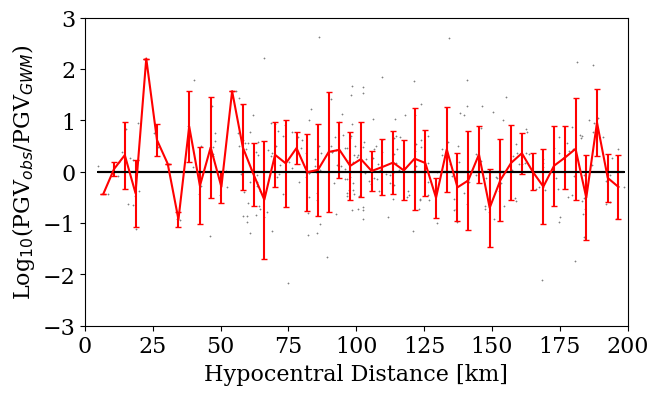

In [6]:
PGV_geom_mean_obs = dataset_generated_pgv["PGV_geom_mean_obs"]
PGV_geom_mean_gm0 = dataset_generated_pgv["PGV_geom_mean_gwm"]

dataset_generated_stats_PGV = calculate_distance_binned_ratios(
    PGV_geom_mean_obs, PGV_geom_mean_gm0, dataset_generated.hypocentral_distance, n_bins=50
)

fig = plt.figure(figsize=(7, 4))
ax = fig.gca()
ax.plot(
    dataset_generated.hypocentral_distance,
    dataset_generated_stats_PGV["ratio_values"],
    "o",
    c="grey",
    markersize=1,
    markeredgewidth=0.2,
    markeredgecolor="grey",
)
ax.errorbar(
    dataset_generated_stats_PGV["bin_centers"],
    dataset_generated_stats_PGV["median_ratios"],
    yerr=dataset_generated_stats_PGA["std_ratios"],
    color="r",
    capsize=2,
)
ax.plot(
    dataset_generated.hypocentral_distance,
    np.ones(len(dataset_generated.hypocentral_distance)) * 0,
    "-",
    color="k",
)
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3, 3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGV$_{obs}$/PGV$_{GWM}$)")
fig.savefig("figures/gwm_stead_PGV_distance.svg", dpi=300, bbox_inches="tight")

## Compare the waveforms and the corresponding Fourier amplitude spectra

                    PARAMETER SUMMARY
Magnitude = 4.56
Hypocentral Distance =106.55 km
Vs30 = 964 m/s
Hypocenter Depth = 57.31 km
Azimuthal gap = 140.91331764492898 degree


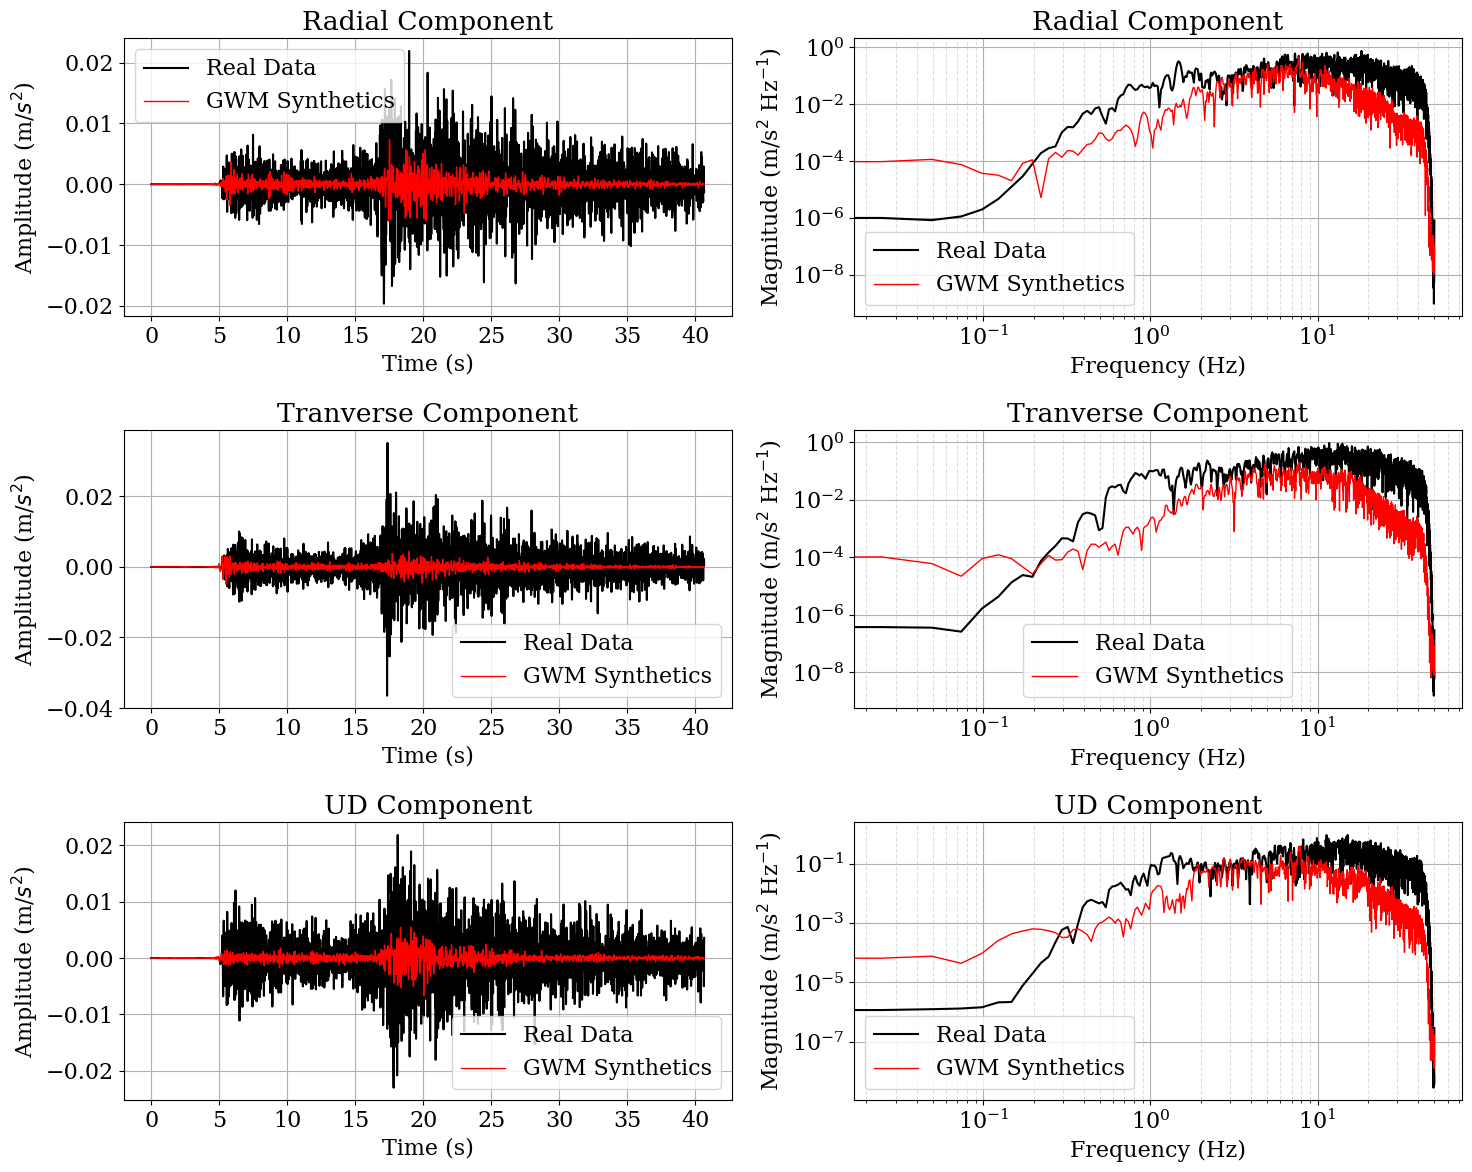

In [12]:
idx = 2  # 24
print("=" * 60)
print("                    PARAMETER SUMMARY")
print("=" * 60)
print("Magnitude = " + str(dataset_observed.magnitude[idx]))
print("Hypocentral Distance =" + str(dataset_observed.hypocentral_distance[idx]) + " km")
print("Vs30 = " + str(dataset_observed.vs30s[idx]) + " m/s")
print("Hypocenter Depth = " + str(dataset_observed.hypocentre_depth[idx]) + " km")
print("Azimuthal gap = " + str(dataset_observed.azimuthal_gap[idx]) + " degree")
fig, fft_freqs, _ = compare_waveforms(
    dataset_observed.waveforms[idx, :, :4064],
    dataset_generated.waveforms[idx, :, :],
    100,
    labels=["Real Data", "GWM Synthetics"],
)
fig.savefig("figures/waveforms_compare_stead_2.png", dpi=300, bbox_inches="tight")

## Bins of seismogram envelope and Fourier amplitude spectra

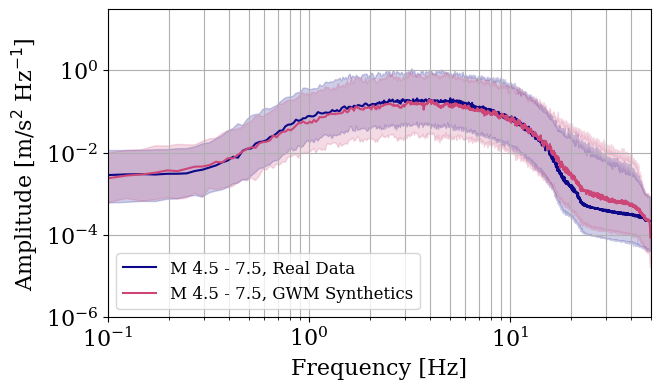

In [14]:
mag_bins = [4.5, 7.5]
dist_bins = [0, 190]
mag_observed = dataset_observed.magnitude
dist_observed = dataset_observed.hypocentral_distance
chan = 1

mags = []
for ii in range(len(mag_bins) - 1):
    for jj in [0]:
        mask1 = (mag_observed >= mag_bins[ii]) & (mag_observed < mag_bins[ii + 1])
        mask2 = (dist_observed >= dist_bins[jj]) & (dist_observed < dist_bins[jj + 1])
        mask = mask1 & mask2
        mags.append(mask)

fig = plt.figure(figsize=(7, 4))
ax = fig.gca()
colors = plt.cm.plasma(np.linspace(0, 1, len(mag_bins) - 1 + 2))

for i in range(len(mags)):
    fft_signal_total_reverse = []
    pos = len(np.where(mags[i] == True)[0])
    wave_filt = dataset_observed.waveforms[mags[i], :, :]
    for j in range(pos):
        freq, fft_signal = fft(wave_filt[j, chan, :4064])
        fft_signal_total_reverse.append(fft_signal)
    fft_signal_total_reverse = np.array(fft_signal_total_reverse)
    fft_signal_mean = np.percentile(fft_signal_total_reverse, 50, axis=0)
    fft_signal_mean_16 = np.percentile(fft_signal_total_reverse, 16, axis=0)
    fft_signal_mean_84 = np.percentile(fft_signal_total_reverse, 84, axis=0)

    ax.loglog(
        freq,
        fft_signal_mean,
        color=colors[i],
        label=f"M {mag_bins[i]} - {mag_bins[i + 1]}, Real Data",
    )
    ax.fill_between(freq, fft_signal_mean_16, fft_signal_mean_84, color=colors[i], alpha=0.2)

    fft_signal_total_reverse = []
    pos = len(np.where(mags[i] == True)[0])
    wave_filt = dataset_generated.waveforms[mags[i], :, :]
    for j in range(pos):
        freq, fft_signal = fft(wave_filt[j, chan, :4064])
        fft_signal_total_reverse.append(fft_signal)
    fft_signal_total_reverse = np.array(fft_signal_total_reverse)
    fft_signal_mean = np.percentile(fft_signal_total_reverse, 50, axis=0)
    fft_signal_mean_16 = np.percentile(fft_signal_total_reverse, 16, axis=0)
    fft_signal_mean_84 = np.percentile(fft_signal_total_reverse, 84, axis=0)

    ax.loglog(
        freq,
        fft_signal_mean,
        color=colors[i + 1],
        label=f"M {mag_bins[i]} - {mag_bins[i + 1]}, GWM Synthetics",
    )
    ax.fill_between(freq, fft_signal_mean_16, fft_signal_mean_84, color=colors[i + 1], alpha=0.2)

ax.grid(which="both")
ax.set_xlim(0.1, 50)
ax.set_ylim(1e-6, 30)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude [m/s$^2$ Hz$^{-1}$]")
ax.legend(fontsize=12)
fig.savefig(f"figures/fft_all_stead_{chan}.svg", dpi=300, bbox_inches="tight")

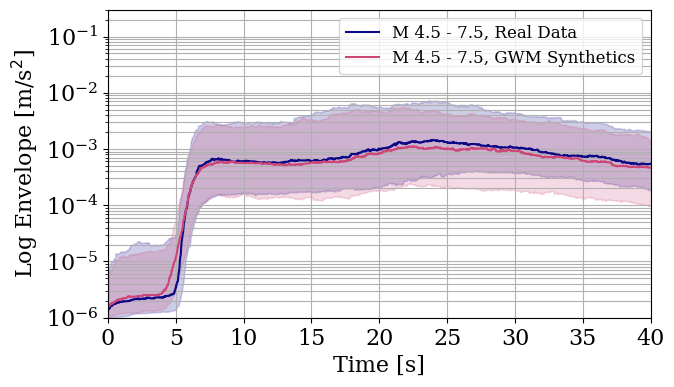

In [15]:
fig = plt.figure(figsize=(7, 4))
ax = fig.gca()
colors = plt.cm.plasma(np.linspace(0, 1, len(mag_bins) - 1 + 2))

for i in range(len(mag_bins) - 1):
    moving_average_signal_total_reverse = []
    pos = len(np.where(mags[i] == True)[0])
    wave_filt = dataset_observed.waveforms[mags[i], :, :]
    for j in range(pos):
        moving_average_signal = moving_average_envelope_adaptive(
            wave_filt[j, chan, :4064], window_size=128
        )
        time = np.linspace(0, len(moving_average_signal) * 0.01, len(moving_average_signal))
        moving_average_signal_total_reverse.append(moving_average_signal)
    moving_average_signal_total_reverse = np.array(moving_average_signal_total_reverse)
    moving_average_mean = np.percentile(moving_average_signal_total_reverse, 50, axis=0)
    moving_average_mean_16 = np.percentile(moving_average_signal_total_reverse, 16, axis=0)
    moving_average_mean_84 = np.percentile(moving_average_signal_total_reverse, 84, axis=0)

    ax.semilogy(
        time,
        moving_average_mean,
        color=colors[i],
        label=f"M {mag_bins[i]} - {mag_bins[i + 1]}, Real Data",
    )
    ax.fill_between(
        time, moving_average_mean_16, moving_average_mean_84, color=colors[i], alpha=0.2
    )

    moving_average_signal_total_reverse = []
    pos = len(np.where(mags[i] == True)[0])
    wave_filt = dataset_generated.waveforms[mags[i], :, :]
    for j in range(pos):
        moving_average_signal = moving_average_envelope_adaptive(
            wave_filt[j, chan, :], window_size=128
        )
        time = np.linspace(0, len(moving_average_signal) * 0.01, len(moving_average_signal))
        moving_average_signal_total_reverse.append(moving_average_signal)
    moving_average_signal_total_reverse = np.array(moving_average_signal_total_reverse)
    moving_average_mean = np.percentile(moving_average_signal_total_reverse, 50, axis=0)
    moving_average_mean_16 = np.percentile(moving_average_signal_total_reverse, 16, axis=0)
    moving_average_mean_84 = np.percentile(moving_average_signal_total_reverse, 84, axis=0)

    ax.semilogy(
        time,
        moving_average_mean,
        color=colors[i + 1],
        label=f"M {mag_bins[i]} - {mag_bins[i + 1]}, GWM Synthetics",
    )
    ax.fill_between(
        time, moving_average_mean_16, moving_average_mean_84, color=colors[i + 1], alpha=0.2
    )

ax.grid(which="both")
ax.set_xlim(0, 40)
ax.set_ylim(1e-6, 3e-1)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Log Envelope [m/s$^2$]")
ax.legend(fontsize=12)
fig.savefig(f"figures/envelope_stead_{chan}.svg", dpi=300, bbox_inches="tight")